8. Using the carseats data set, we will predict sales using regression trees and related approaches, treating the response as a quantitative variable

In [1]:
import os
import pandas as pd

In [2]:
direct = os.getcwd()
carPath = os.path.join(direct, 'carseats.csv')
carseat = pd.read_csv(carPath)

In [3]:
def sl_quant(val):
    if val == 'Bad':
        return 0
    elif val == 'Medium':
        return 1
    else:
        return 2

In [4]:
carseat['ShelveLoc_quant'] = carseat['ShelveLoc'].apply(lambda x: sl_quant(x))
carseat['Urban_io'] = carseat['Urban'].apply(lambda x: 1 if x=='Yes' else 0)
carseat['US_io'] = carseat['US'].apply(lambda x: 1 if x=='Yes' else 0)
carseat = carseat.drop(columns=['ShelveLoc', 'Urban', 'US'])

a) split the data into a training and test set

In [5]:
y_data = carseat['Sales']
x_data = carseat.drop(columns = ['Sales'])

In [6]:
from sklearn.model_selection import train_test_split as tts
x_train, x_test, y_train, y_test = tts(x_data, y_data, test_size=0.25, random_state=0)

b) Fit a regression tree to the training set.  Plot the tree, and interpret the results.  What test MSE do you obtain?

In [7]:
from sklearn.tree import DecisionTreeRegressor as dtReg

tree = dtReg(random_state=0)
model = tree.fit(x_train, y_train)

In [8]:
''' The following plots the tree, but it is uninterpretable

from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(25,20))
_ = plot_tree(tree, 
                   feature_names=x_data.columns,  
                   class_names='Sales',
                   filled=True)
                   
'''

" The following plots the tree, but it is uninterpretable\n\nfrom sklearn.tree import plot_tree\nfrom matplotlib import pyplot as plt\n\nfig = plt.figure(figsize=(25,20))\n_ = plot_tree(tree, \n                   feature_names=x_data.columns,  \n                   class_names='Sales',\n                   filled=True)\n                   \n"

In [9]:
from sklearn.metrics import mean_squared_error as mse
mse(y_test, tree.predict(x_test))

5.191509000000001

c) Use cross validation to determine the optimal value of tree complexity.  Does pruning improve the test MSE?

In [14]:
data = []
for i in range(1, 15):
    tree = dtReg(random_state=0, max_depth=i)
    model = tree.fit(x_train, y_train)
    test_error = mse(y_test, tree.predict(x_test))
    data.append([i, test_error])

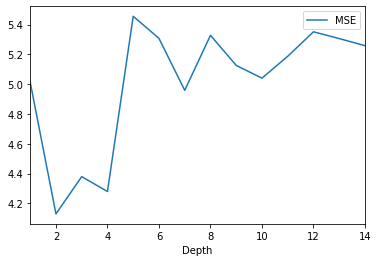

In [15]:
d = pd.DataFrame(data, columns=['Depth', 'MSE'])
d.plot(x='Depth', y='MSE');

In [16]:
data = []
for i in range(0, 50, 5):
    alpha = i/100.0
    tree = dtReg(random_state=0, max_depth=4, ccp_alpha = alpha)
    model = tree.fit(x_train, y_train)
    test_error = mse(y_test, tree.predict(x_test))
    data.append([alpha, test_error])

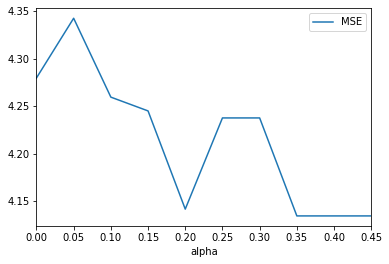

In [17]:
d = pd.DataFrame(data, columns=['alpha', 'MSE'])
d.plot(x='alpha', y='MSE');

****Answer:**** Yes, pruning improves the test MSE

d) Use the bagging approach in order to analyze this data.  What test MSE do you obtain?  Determine which variables are the most important.

In [18]:
from sklearn.ensemble import BaggingRegressor as bagReg
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score as cvScore

tree = dtReg(random_state=0, max_depth = 4)
trees = 100
bags = bagReg(base_estimator=tree, n_estimators = trees, random_state=0)
model = bags.fit(x_train, y_train)
mse(y_test, model.predict(x_test))

2.836586976453146

In [19]:
import numpy as np
feature_importances = np.mean([
    tree.feature_importances_ for tree in bags.estimators_
], axis=0)

features = pd.concat((pd.DataFrame(x_train.columns, columns=['variable']),
                     pd.DataFrame(feature_importances, columns=['importance'])),
                    axis=1).sort_values(by='importance', ascending=False)
print(features)

          variable  importance
7  ShelveLoc_quant    0.417512
4            Price    0.334558
5              Age    0.085665
0        CompPrice    0.054605
2      Advertising    0.050001
1           Income    0.025054
6        Education    0.015179
3       Population    0.013571
9            US_io    0.002728
8         Urban_io    0.001127


e) Use random forests to do the same as d

In [20]:
from sklearn.ensemble import RandomForestRegressor as rfReg
rf = rfReg(random_state=0, max_depth=4, n_estimators=100)
model = rf.fit(x_train, y_train)
mse(y_test, model.predict(x_test))

2.8287435345120566

In [21]:
features = pd.concat((pd.DataFrame(x_train.columns, columns=['variable']),
                     pd.DataFrame(model.feature_importances_, columns=['importance'])),
                    axis=1).sort_values(by='importance', ascending=False)
print(features)

          variable  importance
7  ShelveLoc_quant    0.417521
4            Price    0.333724
5              Age    0.086000
0        CompPrice    0.054267
2      Advertising    0.049416
1           Income    0.025477
6        Education    0.015533
3       Population    0.013839
9            US_io    0.002642
8         Urban_io    0.001581


***


10) We will use boosting to predict salary in the Hitters dataset

a) Remove the observations for which there is no salary info and then log-transform the salaries.

In [22]:
hitters = pd.read_csv(os.path.join(direct, 'hitters.csv'))

In [23]:
hitters.dropna(subset = ['Salary'], inplace=True)

In [24]:
hitters['Salary_log'] = np.log(hitters['Salary'])
hitters.drop(columns=['Salary'], inplace=True)

In [25]:
def div(val):
    if val == 'E':
        return 0
    elif val == 'C':
        return 1
    else:
        return 2

In [26]:
hitters['League_N'] = hitters['League'].apply(lambda x: 1 if x == 'N' else 0)
hitters['NewLeague_N'] = hitters['NewLeague'].apply(lambda x: 1 if x == 'N' else 0)
hitters['Division_ECW_012'] = hitters['Division'].apply(lambda x: div(x))

hitters.drop(columns = ['Hitter', 'League', 'NewLeague', 'Division'], inplace=True)

b) create a training set consisting of the first 200 observations, and a test set consisting of the rest

In [27]:
train = hitters.head(200)
test = hitters.drop(train.index)

response = 'Salary_log'
y_train = train[response]
x_train = train.drop(columns = [response])

y_test = test[response]
x_test = test.drop(columns = [response])

c) Perform boosting on the training set with 1000 trees for a range of values of the shrinkage parameter (lambda).  Produce a plot with different shrinkage values on the x-axis and the corresponding training set MSE on the y-axis.

In [28]:
num_trees = 1000

from sklearn.ensemble import GradientBoostingRegressor as boostReg

data = []
for i in range(1, 90, 5):
    alpha = i/100.0
    boostTree = boostReg(n_estimators = num_trees, learning_rate=alpha, max_depth = 1, random_state=0)
    boostTree.fit(x_train, y_train)

    error = mse(y_train, boostTree.predict(x_train))
    data.append([alpha, error])

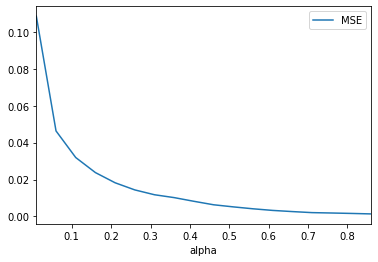

In [29]:
d = pd.DataFrame(data, columns=['alpha', 'MSE'])
d.plot(x='alpha', y='MSE');

d) do the same, but with test MSE, instead of train MSE

In [30]:
num_trees = 1000

from sklearn.ensemble import GradientBoostingRegressor as boostReg

data = []
for i in range(1, 90, 5):
    alpha = i/100.0
    boostTree = boostReg(n_estimators = num_trees, learning_rate=alpha, max_depth = 1, random_state=0)
    boostTree.fit(x_train, y_train)

    error = mse(y_test, boostTree.predict(x_test))
    data.append([alpha, error])

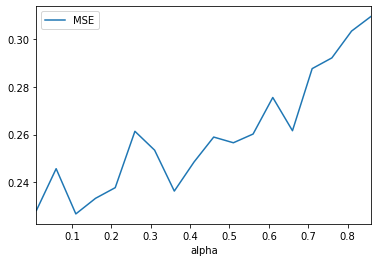

In [31]:
d = pd.DataFrame(data, columns=['alpha', 'MSE'])
d.plot(x='alpha', y='MSE');

f) which variables seem to be the most important predictors in the boosted model?

In [32]:
boostTree = boostReg(n_estimators = num_trees, learning_rate=0.15, max_depth = 1, random_state=0)
model = boostTree.fit(x_train, y_train)

In [33]:
features = pd.concat((pd.DataFrame(x_train.columns, columns=['variable']),
                     pd.DataFrame(model.feature_importances_, columns=['importance'])),
                    axis=1).sort_values(by='importance', ascending=False)
print(features)

            variable  importance
7             CAtBat    0.313312
8              CHits    0.171829
10             CRuns    0.133761
9             CHmRun    0.070665
6              Years    0.061942
1               Hits    0.049012
12            CWalks    0.039780
11              CRBI    0.038897
5              Walks    0.027580
4                RBI    0.023910
0              AtBat    0.020105
13           PutOuts    0.017786
2              HmRun    0.009381
3               Runs    0.008070
15            Errors    0.006132
14           Assists    0.003394
17       NewLeague_N    0.003106
18  Division_ECW_012    0.001338
16          League_N    0.000000


g) Now apply bagging to the training set.  What is the test MSE for this approach

In [34]:
boostingError = mse(y_test, boostTree.predict(x_test))

In [35]:
tree = dtReg(random_state=0)
bags = bagReg(base_estimator = tree, n_estimators=num_trees, random_state = 0)
model = bags.fit(x_train, y_train)
baggingError = mse(y_test, bags.predict(x_test))

In [36]:
print('Boosting Error:  {}\nBagging Error:  {}'.format(boostingError, baggingError))

Boosting Error:  0.23945990725401306
Bagging Error:  0.2305229071755677


***

12) Apply boosting, bagging, and random forests to a data set of your choosing.  How accurate are the results compared to a simple method of linear or logistic regression?  Which method is the best?

We're going to attempt to predict the weight of a vehicle given the other parameters

In [37]:
auto = pd.read_csv(os.path.join(direct, 'auto.csv'))

In [38]:
auto.drop(columns=['name'], inplace=True)
auto2 = auto[auto['horsepower'] == '?']
auto.drop(auto2.index, inplace=True)

In [39]:
response = 'weight'

In [40]:
cutoff = round(auto.shape[0] * 0.75)
cutoff

294

In [41]:
train = auto.head(cutoff)
test = auto.drop(train.index)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

y_train = train[response]
x_train = train.drop(columns = [response])

y_test = test[response]
x_test = test.drop(columns = [response])

#### Boosting

In [42]:
num_trees = 100

from sklearn.ensemble import GradientBoostingRegressor as boostReg

data = []
for i in range(1, 90, 5):
    alpha = i/100.0
    boostTree = boostReg(n_estimators = num_trees, learning_rate=alpha, max_depth = 1, random_state=0)
    boostTree.fit(x_train, y_train)

    error = mse(y_train, boostTree.predict(x_train))
    data.append([alpha, error])

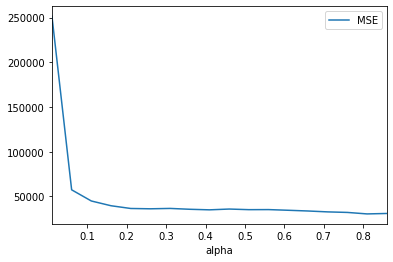

In [43]:
d = pd.DataFrame(data, columns=['alpha', 'MSE'])
d.plot(x='alpha', y='MSE');

In [44]:
data = []
for i in range(1, 90, 5):
    alpha = i/100.0
    boostTree = boostReg(n_estimators = num_trees, learning_rate=alpha, max_depth = 1, random_state=0)
    boostTree.fit(x_train, y_train)

    error = mse(y_test, boostTree.predict(x_test))
    data.append([alpha, error])

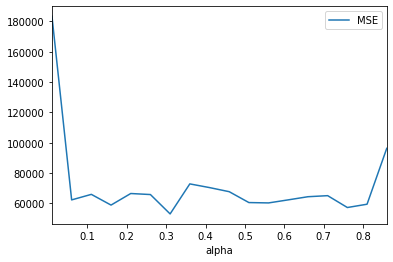

In [45]:
d = pd.DataFrame(data, columns=['alpha', 'MSE'])
d.plot(x='alpha', y='MSE');

Any alpha between 0.1 and 0.3 seems to do well.  We will choose 0.3.

In [46]:
boostTree = boostReg(n_estimators = num_trees, learning_rate=0.3, max_depth = 1, random_state=0)
boostTree.fit(x_train, y_train)

boostingError = mse(y_test, boostTree.predict(x_test))

#### Bagging

In [47]:
data = []
for i in range(1, 15):
    tree = dtReg(random_state=0, max_depth=i)
    model = tree.fit(x_train, y_train)
    test_error = mse(y_test, tree.predict(x_test))
    data.append([i, test_error])

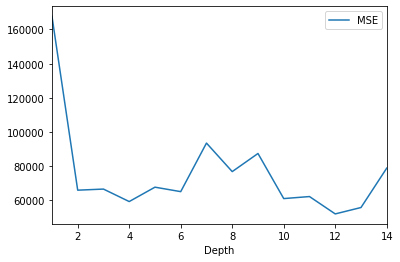

In [48]:
d = pd.DataFrame(data, columns=['Depth', 'MSE'])
d.plot(x='Depth', y='MSE');

In [49]:
tree = dtReg(random_state=0, max_depth = 4)
bags = bagReg(base_estimator=tree, n_estimators = num_trees, random_state=0)
model = bags.fit(x_train, y_train)
baggingError = mse(y_test, model.predict(x_test))

#### Random Forest

In [50]:
from sklearn.ensemble import RandomForestRegressor as rfReg
rf = rfReg(random_state=0, max_depth=4, n_estimators=num_trees)
model = rf.fit(x_train, y_train)
rfError = mse(y_test, rf.predict(x_test))

#### Linear Regression

In [51]:
from sklearn.linear_model import LinearRegression as linReg

reg = linReg()
model = reg.fit(x_train, y_train)

regError = mse(y_test, reg.predict(x_test))

****Results:****

In [52]:
print('Boosting Error:  {}\nBagging Error:  {}\nRandom Forest Error: {}\nLinear Regression Error: {}'.format(boostingError, baggingError, rfError, regError))

Boosting Error:  46462.40338027571
Bagging Error:  47402.04375760207
Random Forest Error: 47559.46687073009
Linear Regression Error: 60740.05028211582
